In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd 
from tensorflow import keras
import keras as k
from matplotlib import pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
import plotly.offline as py
import plotly.graph_objs as go
import keras_tuner as kt
import tensorflow as tf
from IPython.display import SVG
import os
import datetime, time
import random
from keras import backend as K
from keras.regularizers import L1L2
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from keras.losses import MeanSquaredError
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from keras.models import load_model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("gold_price_data.csv")

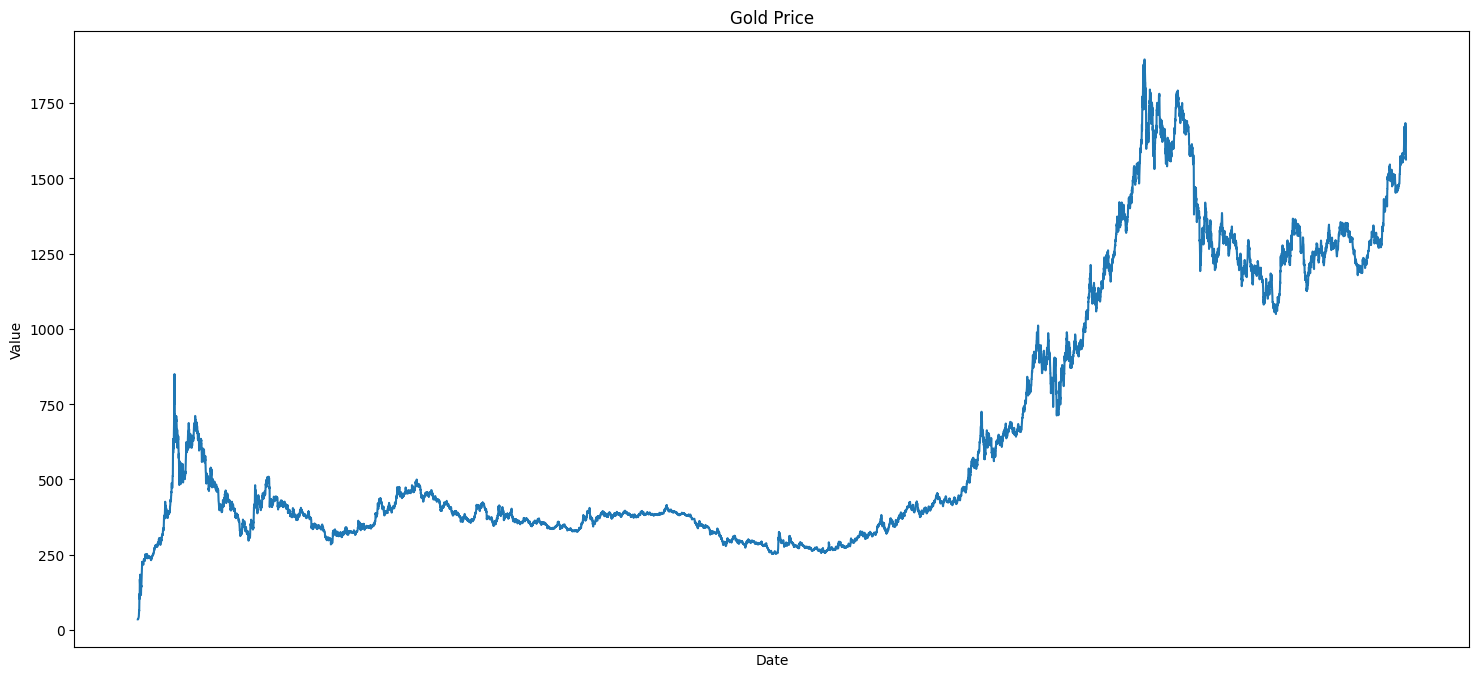

In [3]:
plt.figure(figsize = (18,8))
sns.lineplot(data=df, x="Date" , y="Value")
plt.title('Gold Price')
plt.xticks([]) 
plt.show()

In [4]:
train_len = int(df.shape[0]*0.8)
train = df[0:train_len]
test =df[train_len:]

In [5]:
train

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4
...,...,...
8624,2011-11-30,1746.0
8625,2011-12-01,1752.0
8626,2011-12-02,1747.0
8627,2011-12-05,1744.0


In [6]:
test

,Date,Value
8629,2011-12-07,1735.50
8630,2011-12-08,1715.00
8631,2011-12-09,1709.00
8632,2011-12-12,1659.50
8633,2011-12-13,1672.50
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['Value'].values.reshape(-1, 1))

In [8]:
lookback = 200
def create_sequences(data, lookback):
    X = []
    y = []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y
X_train, y_train = create_sequences(train_scaled, lookback)

In [9]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   input_shape=(X_train.shape[1], 1),
                   activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(lr=hp.Float('learning_rate', min_value=1e-6, max_value=1e-3, sampling='LOG')),
                  loss=MeanSquaredError())
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='xau_pred',
    project_name='xau_price_prediction'
)
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           min_delta=0, 
                                           patience=5, 
                                           verbose=0, 
                                           mode='auto')]

tuner.search(X_train, y_train,
             epochs=7,
             batch_size=16,
             validation_split=0.2)


INFO:tensorflow:Reloading Tuner from xau_pred\xau_price_prediction\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [10]:
tuner.results_summary()

Results summary
Results in xau_pred\xau_price_prediction
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 07 summary
Hyperparameters:
units: 128
activation: tanh
learning_rate: 0.0008484106567304556
Score: 0.0001597085065441206

Trial 03 summary
Hyperparameters:
units: 448
activation: tanh
learning_rate: 0.00012700356073649282
Score: 0.0002368845889577642

Trial 01 summary
Hyperparameters:
units: 384
activation: relu
learning_rate: 9.649381438704535e-05
Score: 0.0005263558705337346

Trial 02 summary
Hyperparameters:
units: 480
activation: tanh
learning_rate: 2.8202517969162182e-05
Score: 0.0007892637513577938

Trial 08 summary
Hyperparameters:
units: 160
activation: sigmoid
learning_rate: 0.00014082021887037045
Score: 0.003611588152125478

Trial 00 summary
Hyperparameters:
units: 128
activation: relu
learning_rate: 1.2387625173820791e-05
Score: 0.011838959529995918

Trial 09 summary
Hyperparameters:
units: 288
activation: relu
learning_rate: 5.386054127339182e-

In [11]:
best_model = tuner.get_best_models(num_models=1)[0]

In [12]:
best_model.save('bestmodel200')

INFO:tensorflow:Assets written to: bestmodel200\assets


INFO:tensorflow:Assets written to: bestmodel200\assets


In [13]:
inputs = df['Value'].values[len(df) - len(test) - lookback:]
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test, y_test = create_sequences(inputs, lookback)

In [14]:
predictions = best_model.predict(X_test)

68/68 [==============================] - 3s 40ms/step


In [15]:
predictions = scaler.inverse_transform(predictions)

In [16]:
mape = mean_absolute_percentage_error(test['Value'].values, predictions)
print("MAPE:", mape)

MAPE: 0.010967511240456624


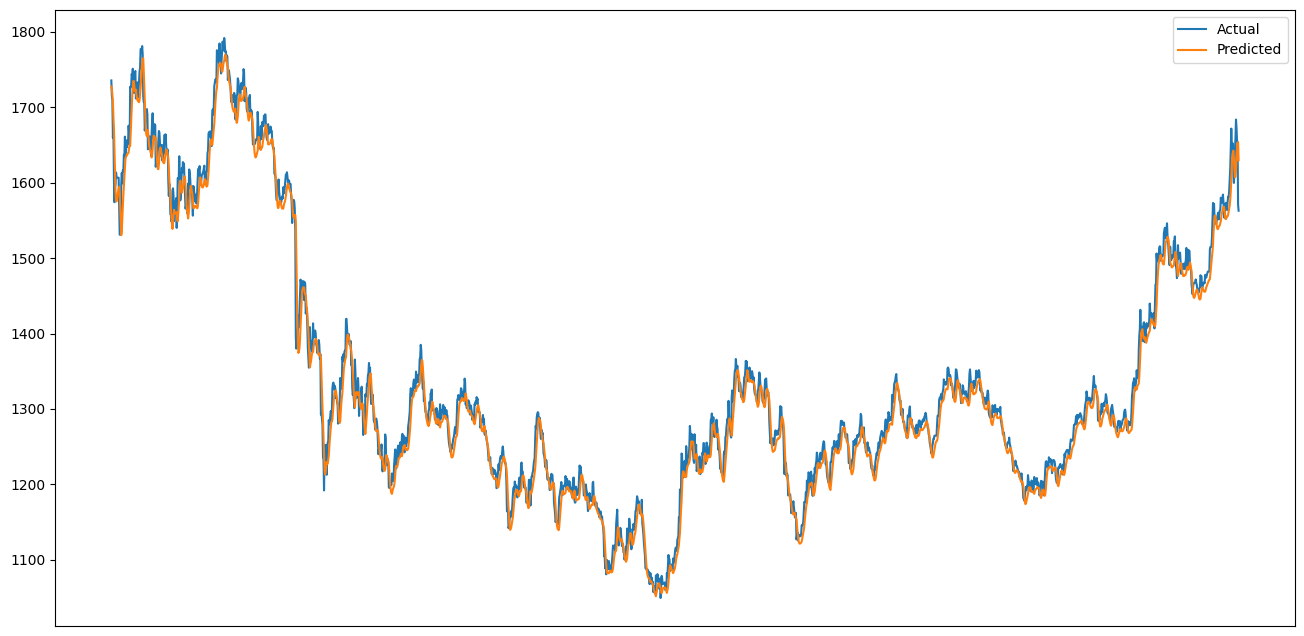

In [17]:
plt.figure(figsize=(16,8))
plt.plot(test['Value'].values)
plt.plot(predictions)
plt.legend(['Actual', 'Predicted'])
plt.xticks([]) 
plt.show()

In [18]:
a_actual = np.trapz(test['Value'].values)
a_predicted = np.trapz(predictions.flatten())
a_diff = a_actual - a_predicted
print("Actual area under curve:",a_actual)
print("Predicted area under curve:",a_predicted)
print ("Difference between actual and predicted areas:",a_diff)

Actual area under curve: 2894999.05
Predicted area under curve: 2875257.2
Difference between actual and predicted areas: 19741.799999999814


In [19]:
model = load_model('bestmodel200')
df = pd.read_csv('gold_price_data.csv')

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Value'].values.reshape(-1, 1))

loookback = 200

def create_sequences(data, lookback):
    X = []
    y = []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

X, y = create_sequences(scaled_data, lookback)

In [21]:
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)
df['Predictions'] = np.nan
df.iloc[lookback:len(df), -1] = predictions.reshape(-1)

331/331 [==============================] - 13s 37ms/step


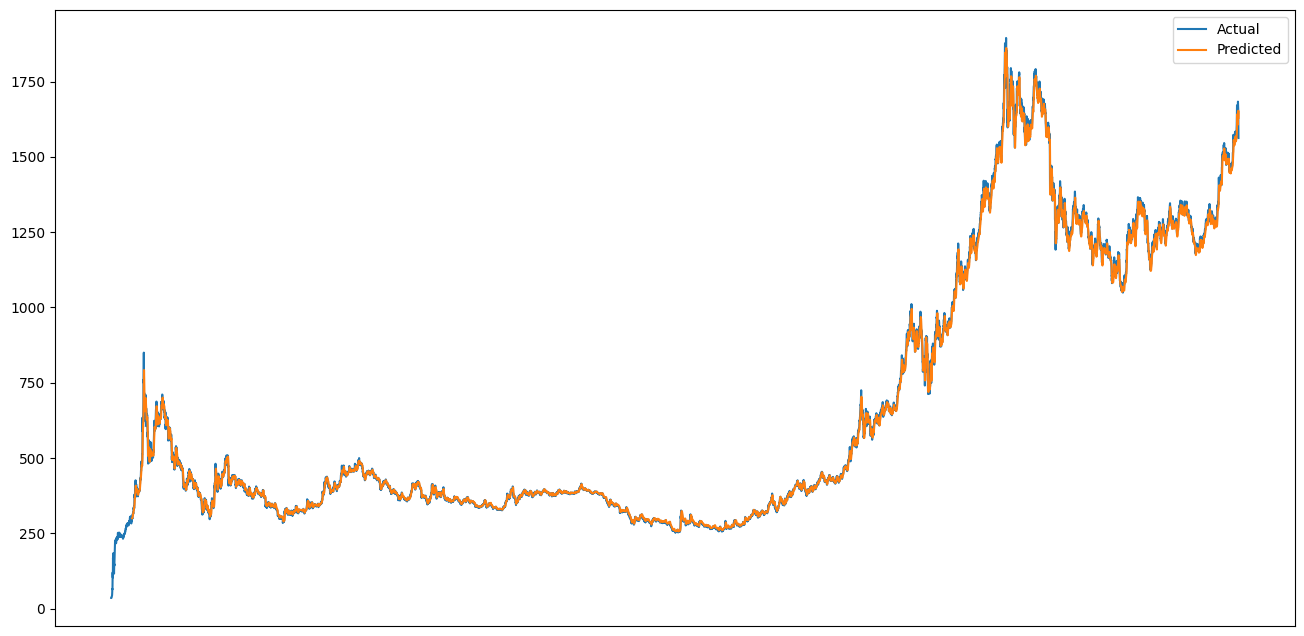

In [22]:
plt.figure(figsize=(16,8))
plt.plot(df['Value'].values)
plt.plot(df['Predictions'].values)
plt.legend(['Actual', 'Predicted'])
plt.xticks([]) 
plt.show()

In [23]:
test_data = df.iloc[-len(predictions):]['Value'].values
mape = np.mean(np.abs(test_data - predictions) / test_data) * 100
print("MAPE:", mape)

MAPE: 79.20689251483466


In [24]:
a_actual = np.trapz(test['Value'].values)
a_predicted = np.trapz(predictions.flatten())
a_diff = a_actual - a_predicted
print("Actual area under curve:",a_actual)
print("Predicted area under curve:",a_predicted)
print ("Difference between actual and predicted areas:",a_diff)

Actual area under curve: 2894999.05
Predicted area under curve: 6976449.5
Difference between actual and predicted areas: -4081450.45
